# 0. Package Install 


---

주요 패키지



1.   ```Torch_geometric```
2.   ```Mendeleev```
3.   ```RDKit```

*숨겨진 셀들을 아래의 실행버튼을 통해서 보지 않고 수행될 수 있도록 해주세요*

In [1]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
# https://gist.github.com/ameya98
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter==latest+{CUDA}     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-sparse==latest+{CUDA}      -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-cluster==latest+{CUDA}     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-spline-conv==latest+{CUDA} -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-geometric 
!pip install mendeleev
# !pip install rdkit

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 18.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 1.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 1.4MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 34.4MB/s 
     |████████████████████████████████| 194kB 32.1MB/s 
     |████████████████████████████████| 235kB 42.0MB/s 
     |████████████████████████████████| 2.2MB 55.6MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=0b7eb35b6f9d13439b4dac8d7c68fa0edec40ad3aa2a838ea904292fce6c8927
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a3367c091694eebc50a971


In [2]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
  install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [3]:
import numpy as np
import pandas as pd
import random

from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_geometric.data import Data
from torch_geometric.data import DataLoader
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

from tqdm import tqdm

from mendeleev import get_table
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem import Descriptors as desc
from rdkit.Chem import Crippen
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem import MolSurf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as geonn

# 1. Load DataSet & preprocessing 


---

사용할 데이터를 불러오고, 학습에 사용할 DataSet으로 구성



In [4]:
# Load node Feature Table 
def get_elem_feats():
    # 기존 Preprocessing 을 수행하지 않은 데이터를 그대로 사용하던 코드 
    # tb_atom_feats = get_table('elements')
    # elem_feats = numpy.nan_to_num(numpy.array(tb_atom_feats[elem_feat_names]))

    tb_atom_feats = pd.read_excel("/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/2_GNN/data/LOHC_MLproject_POSTECH/final_mendel.xlsx")
    elem_feats = np.array(tb_atom_feats[elem_feat_names])
    return elem_feats

# Load smiles Data 
def load_dataset(path_user_dataset):
    elem_feats = get_elem_feats()
    list_mols = np.zeros((1,2))
    id_target = np.array(pd.read_excel(path_user_dataset))

    for i in tqdm(range(0, id_target.shape[0])):
        mol = smiles_to_mol_graph(elem_feats, id_target[i, 0], idx=i, target=id_target[i, 1])

        if mol is not None:
          sample = np.array([id_target[i, 0], mol])
          list_mols = np.append(list_mols,
                                np.expand_dims(sample, axis=0),
                                axis=0)

    return list_mols[1:]

# Convert smiles to torch embedding molecular features
def smiles_to_mol_graph(elem_feats, smiles, idx, target):
    try:
        mol = Chem.MolFromSmiles(smiles)
        adj_mat = Chem.GetAdjacencyMatrix(mol)
        # adding Identity Matrix 
        # adj_mat = adj_mat + numpy.eye(len(adj_mat)) 
        atom_feats = list()
        bonds = list()

        for atom in mol.GetAtoms():
            atom_feats.append(elem_feats[atom.GetAtomicNum() - 1, :])

        for i in range(0, mol.GetNumAtoms()):
            for j in range(0, mol.GetNumAtoms()):
                if adj_mat[i, j] == 1:
                    bonds.append([i, j])

        if len(bonds) == 0:
            return None

        atom_feats = torch.tensor(atom_feats, dtype=torch.float)
        bonds = torch.tensor(bonds, dtype=torch.long).t().contiguous()
        y = torch.tensor(target, dtype=torch.float).view(1, 1)
        # for eGCN 
        MW = torch.tensor(ExactMolWt(mol)).view(1, 1)
        LOGP = torch.tensor(Crippen.MolLogP(mol)).view(1, 1)
        HBA = torch.tensor(Lipinski.NumHAcceptors(mol)).view(1, 1)
        HBD = torch.tensor(Lipinski.NumHDonors(mol)).view(1, 1)
        rotable = torch.tensor(Lipinski.NumRotatableBonds(mol)).view(1, 1)
        amide = torch.tensor(AllChem.CalcNumAmideBonds(mol)).view(1, 1)
        bridge = torch.tensor(AllChem.CalcNumBridgeheadAtoms(mol)).view(1, 1)
        heteroA = torch.tensor(Lipinski.NumHeteroatoms(mol)).view(1, 1)
        heavy = torch.tensor(Lipinski.HeavyAtomCount(mol)).view(1, 1)
        spiro = torch.tensor(AllChem.CalcNumSpiroAtoms(mol)).view(1, 1)
        FCSP3 = torch.tensor(AllChem.CalcFractionCSP3(mol)).view(1, 1)
        ring = torch.tensor(Lipinski.RingCount(mol)).view(1, 1)
        Aliphatic = torch.tensor(AllChem.CalcNumAliphaticRings(mol)).view(1, 1)
        aromatic = torch.tensor(AllChem.CalcNumAromaticRings(mol)).view(1, 1)
        saturated = torch.tensor(AllChem.CalcNumSaturatedRings(mol)).view(1, 1)
        heteroR = torch.tensor(AllChem.CalcNumHeterocycles(mol)).view(1, 1)
        TPSA = torch.tensor(MolSurf.TPSA(mol)).view(1, 1)
        valence = torch.tensor(desc.NumValenceElectrons(mol)).view(1, 1)
        mr = torch.tensor(Crippen.MolMR(mol)).view(1, 1)

        return Data(x=atom_feats, y=y, edge_index=bonds, idx=idx,
                    MW=MW, LOGP=LOGP, HBA=HBA, HBD=HBD, rotable=rotable, amide=amide, bridge=bridge, heteroA=heteroA, heavy=heavy, spiro=spiro, FCSP3=FCSP3, ring=ring, Aliphatic=Aliphatic, aromatic=aromatic, saturated=saturated, heteroR=heteroR, TPSA=TPSA, valence=valence, mr=mr)
    except:
        return 


In [5]:
# Node(Atomic) Features로 사용할 columns 지정
elem_feat_names = ['atomic_weight', 'atomic_radius', 'atomic_volume', 'dipole_polarizability',
                   'fusion_heat', 'thermal_conductivity', 'vdw_radius', 'en_pauling',
                    'boiling_point','electron_affinity','en_allen','en_ghosh']
n_atom_feats = len(elem_feat_names)

In [6]:
# Load dataset
DataPath = "/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/2_GNN/data/LOHC_MLproject_POSTECH/Dehydrogenation3.xlsx"

print('Load molecular structures...')
dataSet = load_dataset(DataPath)

Load molecular structures...


100%|██████████| 1465/1465 [00:03<00:00, 367.97it/s]


# 2. Train, Validate and Test 


---

학습에 사용될 함수 정의



In [7]:
def train(model, optimizer, data_loader, criterion):
    model.train()
    train_loss = 0

    for i, (batch) in enumerate(data_loader):
        
        pred = model(batch.to(DEVICE))
        loss = criterion(batch.y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)

def validate(model, data_loader, criterion):
  model.eval()
  val_loss =0
  
  with torch.no_grad():
    for i, (batch) in enumerate(data_loader):
        preds = model(batch.to(DEVICE))
        loss = criterion(preds, batch.y)
        val_loss += loss.item()

    val_loss = val_loss / len(data_loader)
  
  return val_loss

def test(model, data_loader):
    model.eval()
    list_preds = list()
    
    with torch.no_grad():
        for batch in data_loader:
            preds = model(batch.to(DEVICE))
            list_preds.append(preds)

    return torch.cat(list_preds, dim=0).cpu().numpy()

# 3. Model Construction


---

학습에 사용할 모델의 구조 설계



In [8]:
class EGCN(nn.Module):
    # extended graph convolutional network
    def __init__(self, args):
        super(EGCN, self).__init__()
        self.input_dim = args.input_dim
        self.hidden_dim = args.hidden_dim
        self.out_dim = args.out_dim
        
        # self.Norm = "Layer"
        # self.sc = "gated"
        # self.attention = False
        self.drop_p = args.drop_p

        self.gc1 = geonn.GCNConv(self.input_dim, self.hidden_dim)
        self.norm1 = geonn.LayerNorm(self.hidden_dim)

        self.gc2 = geonn.GCNConv(self.hidden_dim, self.hidden_dim)
        self.norm2 = geonn.LayerNorm(self.hidden_dim)

        self.gc3 = geonn.GCNConv(self.hidden_dim, self.hidden_dim)
        self.norm3 = geonn.LayerNorm(self.hidden_dim)

        self.fc1 = nn.Linear(self.hidden_dim + 19, self.hidden_dim*2)
        self.drop1 = nn.Dropout(p= self.drop_p)

        self.fc2 = nn.Linear(self.hidden_dim*2, self.hidden_dim*2)
        self.drop2 = nn.Dropout(p= self.drop_p)

        self.fc3 = nn.Linear(self.hidden_dim*2, self.out_dim)

    def forward(self, g):
        # Conv Layer 1
        h1 = self.gc1(g.x, g.edge_index)
        h1 = self.norm1(h1)
        h1 = F.relu(h1)

        # Conv Layer 2
        h2 = self.gc2(h1, g.edge_index)
        h2 = self.norm2(h2)
        h2 = F.relu(h2)

        # Conv Layer 3
        h3 = self.gc3(h2, g.edge_index)
        h3 = self.norm3(h3)
        h3 = F.relu(h3)

        # Read Out Layer 
        hg = geonn.global_mean_pool(h3, g.batch)

        # eGCN, concat Layer
        hg = torch.cat([hg, g.MW, g.LOGP, g.HBA, g.HBD, g.rotable, g.amide, g.bridge, g.heteroA, g.heavy, g.spiro, g.FCSP3, g.ring, g.Aliphatic, g.aromatic, g.saturated, g.heteroR, g.TPSA, g.valence,g.mr],
                       dim=1)
        
        # FCN Layer 1 
        hg = self.fc1(hg)
        if self.drop_p :
         hg = self.drop1(hg)
        hg = F.relu(hg)

        # FCN Layer 2 
        hg = self.fc2(hg)
        if self.drop_p :
          hg = self.drop2(hg)
        hg = F.relu(hg)

        # FCN Layer 3 
        out = self.fc3(hg)

        return out

In [9]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)
        
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

# 4. Experiment


---
Set up Hyperparameter, learning param.






In [10]:
import argparse

paser = argparse.ArgumentParser()
args = paser.parse_args("")

In [11]:
# Setting

# 1. Model 
args.input_dim = n_atom_feats
args.hidden_dim = 256
args.out_dim = 1 

# args.Norm = "Layer"
# args.sc = "gated"
# args.attention = False
args.drop_p = 0.5

# 2. learing 
args.batch_size = 32
args.init_lr = 0.001
args.l2_coeff = 0.0
args.n_epochs = 30000

In [12]:
args.MODEL_NAME = 'eGCN' 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.DEVICE = DEVICE
print("MODEL_NAME = {}, DEVICE = {}".format(args.MODEL_NAME,args.DEVICE))

# model = EGCN(input_dim=input_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(DEVICE)
model = EGCN(args).to(DEVICE)

MODEL_NAME = eGCN, DEVICE = cuda


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.init_lr, weight_decay=args.l2_coeff)
criterion = torch.nn.L1Loss()

In [14]:
# Generate training and test datasets

# train : validation : test = 8 : 1 : 1 
train_data, unseen_data = train_test_split(dataSet,test_size=0.2, random_state=400)
validate_data, test_data = train_test_split(unseen_data, test_size=0.5, random_state=400)

train_smiles = train_data[:, 0]
validate_smiles = validate_data[:, 0]
test_smiles = test_data[:, 0]

train_loader = DataLoader(train_data[:, 1], batch_size=args.batch_size, shuffle=True, drop_last=True)
validate_loader = DataLoader(validate_data[:, 1], batch_size=100, drop_last=False)
test_loader = DataLoader(test_data[:, 1], batch_size=100, drop_last=False)

train_targets = np.array([x.y.item() for x in train_data[:,1]]).reshape(-1, 1)
validate_targets = np.array([x.y.item() for x in validate_data[:,1]]).reshape(-1, 1)
test_targets = np.array([x.y.item() for x in test_data[:,1]]).reshape(-1, 1)

In [15]:
# utility function to measure time
import time
import math

all_seq = np.empty((1,4), dtype=float)
train_losses = []
vali_losses = [] 

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# Train graph neural network (GNN)
print('Train the GNN-based predictor...')
start = time.time()
for i in range(0, args.n_epochs):
    train_loss = train(model, optimizer, train_loader, criterion)
    vali_loss = validate(model, validate_loader, criterion)
    print('Time : {:10s} | Epoch [{}/{}]\tTrain loss: {:.4f}\t Vali loss: {:0.4f}'.format(timeSince(start),i + 1, args.n_epochs, train_loss, vali_loss))
    

    # Test the trained GNN

    train_losses.append(train_loss)
    vali_losses.append(vali_loss)
    if (i+1) % 25 == 0 : 
      # model.eval()
      preds = test(model, test_loader)
      test_mae = np.mean(np.abs(test_targets - preds))
      test_std = np.std(test_targets - preds)

      r2 = r2_score(test_targets, preds)
      print("------------------Train Test------------------")
      print("Now Epoch [{}/{}]".format(i+1, n_epochs))
      print('Test MAE: {:.4f}\t Test Std.: {:.4f}\tTest R2 score: {:.4f}'.format(test_mae,test_std, r2))
      print("----------------------------------------------")
      item = np.array((i+1, test_mae, test_std, r2))
      all_seq = np.append(all_seq, np.expand_dims(item, axis=0), axis=0)

Train the GNN-based predictor...
Time : 0m 0s      | Epoch [1/30000]	Train loss: 29.5969	 Vali loss: 22.9229
Time : 0m 1s      | Epoch [2/30000]	Train loss: 20.1410	 Vali loss: 18.3229
Time : 0m 1s      | Epoch [3/30000]	Train loss: 15.5413	 Vali loss: 19.4001
Time : 0m 2s      | Epoch [4/30000]	Train loss: 13.0151	 Vali loss: 8.3537
Time : 0m 3s      | Epoch [5/30000]	Train loss: 11.6789	 Vali loss: 8.2234


KeyboardInterrupt: ignored

잠정적으로 효과가 없음으로 판단, 모델 수정은 추후에 하기로 결론 


# 5. Cross Validation 
---


In [ ]:
def crossValidation(data = None, n_splits = 5, random_state=400, args=None, savePath="./"):
    import os
    import csv 
    from sklearn.model_selection import KFold    
    kfold = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    valid_mae = 0
    
    log_ = savePath + "/_Train_log.csv"
    evaluation_ = savePath + "/_evaluation_log.csv"

    if not os.path.exists(log_):
      with open(log_, mode='w') as f:
        myWriter = csv.writer(f)
        myWriter.writerow(["stage","epoch","loss"])

    if not os.path.exists(evaluation_):
      with open(evaluation_, mode='w') as f:
        myWriter = csv.writer(f)
        myWriter.writerow(["stage","epoch","MAE","Std","R2"])

    for stage, (train_index, validate_index) in enumerate(kfold.split(data)): #cross validation, k=5
        
        print("""

        --- now validation Round : {} ---""".format(stage+1), end="")

        valid_train_data=list()
        validate_data=list()
        
        for i in train_index:
            valid_train_data.append(data[i])
        for i in validate_index:  
            validate_data.append(data[i])

        # MAE 모니터링을 위한 Extract 
        valid_targets=np.array([x.y.item() for x in validate_data]).reshape(-1, 1)

        # KFold에 의해 나누어진 코드들을 학습에 사용하기 위해서 데이터 셋으로 변환 
        valid_train_loader = DataLoader(valid_train_data, batch_size=args.batch_size, shuffle=True)
        valid_loader = DataLoader(validate_data, batch_size=100)

        # 모델 초기화 
        model = EGCN(args).to(args.DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=args.init_lr, weight_decay=args.l2_coeff)
        criterion = torch.nn.L1Loss()

        stage_indicator = "Round : " + str(stage+1) + " | Epoch"
        for idx in tqdm(range(0, args.n_epochs), desc=stage_indicator): #각 cross validation 을 지정된 epoch으로 실행  
            train_loss = train(model, optimizer, valid_train_loader, criterion)


            with open(log_, mode='a') as f:  
              myWriter = csv.writer(f)
              myWriter.writerow([stage,idx+1,train_loss])

            if (idx+1) % 25 == 0 :
              preds = test(model, valid_loader)
              test_mae = np.mean(np.abs(valid_targets - preds))
              test_std = np.std(valid_targets - preds)
              r2 = r2_score(valid_targets, preds)

              with open(evaluation_, mode='a') as f:  
                myWriter = csv.writer(f)
                myWriter.writerow([stage, idx+1, test_mae, test_std, r2])
              # print()
              # print("------------------Train Test------------------")
              # print("Now Epoch [{}/{}]".format(i+1, args.n_epochs))
              # print('Test MAE: {:.4f}\t Test Std.: {:.4f}\tTest R2 score: {:.4f}'.format(test_mae,test_std, r2))
              # print("----------------------------------------------")
              

        preds = test(model, valid_loader)
        valid_targets=np.array([x.y.item() for x in validate_data]).reshape(-1, 1)
        tmp_mae = np.mean(np.abs(valid_targets - preds))
        print(i+1,' validation mae: ',tmp_mae)
        valid_mae = valid_mae+tmp_mae
    
    print('total mae:',valid_mae,' mean mae:',valid_mae/5)


In [ ]:
crossValidation(data = train_data[:,1], n_splits=5, args=args, savePath = "/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/2_GNN/data")

Round : 1 | Epoch:   0%|          | 0/30000 [00:00<?, ?it/s]



        --- now validation Round : 1 ---

Round : 1 | Epoch: 100%|██████████| 30000/30000 [3:57:26<00:00,  2.11it/s]


1170  validation mae:  7.034219863566946


NameError: ignored

In [99]:
from datetime import date, datetime, timezone, timedelta

exp_day = str(date.today())

KST = timezone(timedelta(hours=9))
time_record = datetime.now(KST)
_day = str(time_record)[:10]
_time = str(time_record.time())[:8]

print(exp_day)
print(datetime.now(KST))
print(_day)
print(_time)

2021-02-15
2021-02-15 14:35:36.866411+09:00
2021-02-15
14:35:36


# 6. Visualization
---

In [ ]:
all_seq = all_seq[1:]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg 
sns.set_style("darkgrid", {"axes.facecolor": "gainsboro"})
df = pandas.DataFrame(all_seq, columns=("Epoch","MAE","Std.","R2_score"))

NameError: ignored

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./trend_graph.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


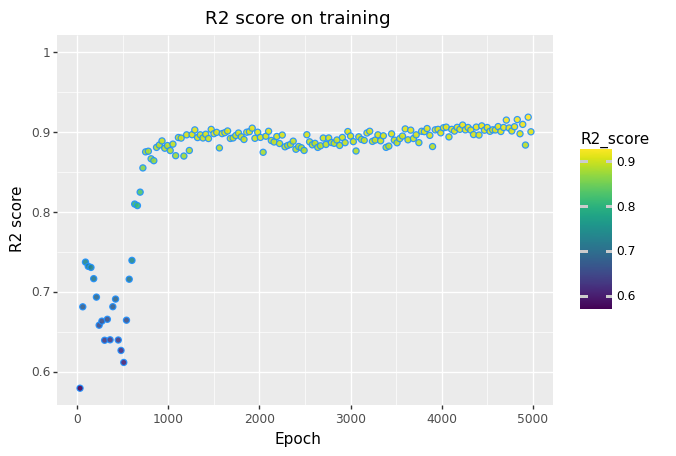

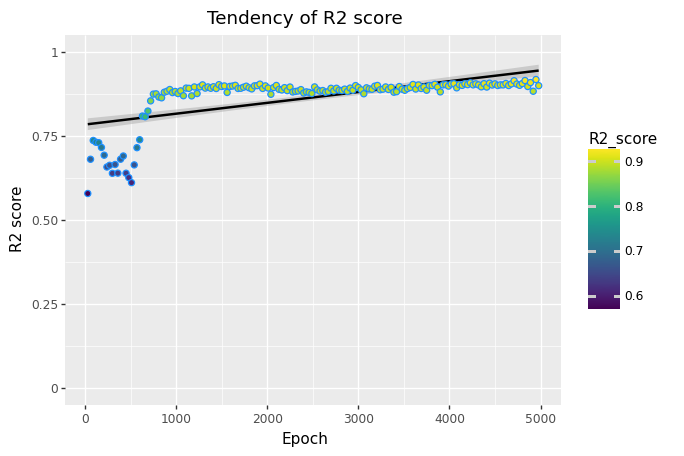

In [ ]:
#  https://blog.naver.com/nife0719/221000580841
df = pd.DataFrame(all_seq, columns=("Epoch","MAE","Std.","R2_score"))

# ggplot(df[["Epoch","R2_Score"]], aes(x="Epoch")) + geom_density(alpha=.1)
score_df = df[["Epoch","R2_score"]]

score_graph = gg.ggplot(score_df, aes(sample="R2_score", x="Epoch", y="R2_score",ymin=0.8, ymax=1, fill="R2_score")) 
score_graph += gg.geom_point(size=2,color="dodgerblue", alpha=0.9)# + geom_qq(size=2,color="blue", alpha=0.9)
score_graph += gg.ggtitle("R2 score on training")
score_graph += gg.labs(x="Epoch", y="R2 score")

trend_graph = gg.ggplot(score_df, aes(x="Epoch",y="R2_score",ymin=0.8, ymax=1, fill="R2_score")) 
# trend_graph += geom_qq(size=2,color="dodgerblue", alpha=0.5) 
# trend_graph += geom_qq_line(size=1.2,color="blue",alpha=0.8) 
# method ['lm', 'ols', 'wls', 'rlm', 'glm', 'gls', 'lowess', 'loess', 'mavg', 'gpr']
"""
'auto'       # Use loess if (n<1000), glm otherwise
            'lm', 'ols'  # Linear Model
            'wls'        # Weighted Linear Model
            'rlm'        # Robust Linear Model
            'glm'        # Generalized linear Model
            'gls'        # Generalized Least Squares
            'lowess'     # Locally Weighted Regression (simple)
            'loess'      # Locally Weighted Regression
            'mavg'       # Moving Average
            'gpr'        # Gaussian Process Regressor
"""
trend_graph += gg.geom_smooth(span=.3, method='gls') 
trend_graph += gg.geom_point(size=2, color="dodgerblue") 
trend_graph += gg.ggtitle("Tendency of R2 score")
trend_graph += gg.labs(x="Epoch", y="R2 score")
trend_graph += gg.ylim(0,1)

score_graph.draw()
trend_graph.draw()

In [ ]:
MAE_df = df[["MAE","Epoch"]]
MAE_df[" "] = "MAE"
MAE_df =MAE_df.rename(columns={"MAE":"value"})
Std_df = df[["Std.","Epoch"]]
Std_df[" "] = "Std."
Std_df =Std_df.rename(columns={"Std.":"value"})
value_df = pd.concat([MAE_df,Std_df], axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Test MAE: 3.2129	Test R2 score: 0.9042
--------------HyperParameter Info--------------
Batch : 32, init_lr : 0.0005, l2_coeff : 0.0, epoch : 5000
criterion : L1Loss(), hidden Channel : 256
Feature Num. : 12
-----------------------------------------------


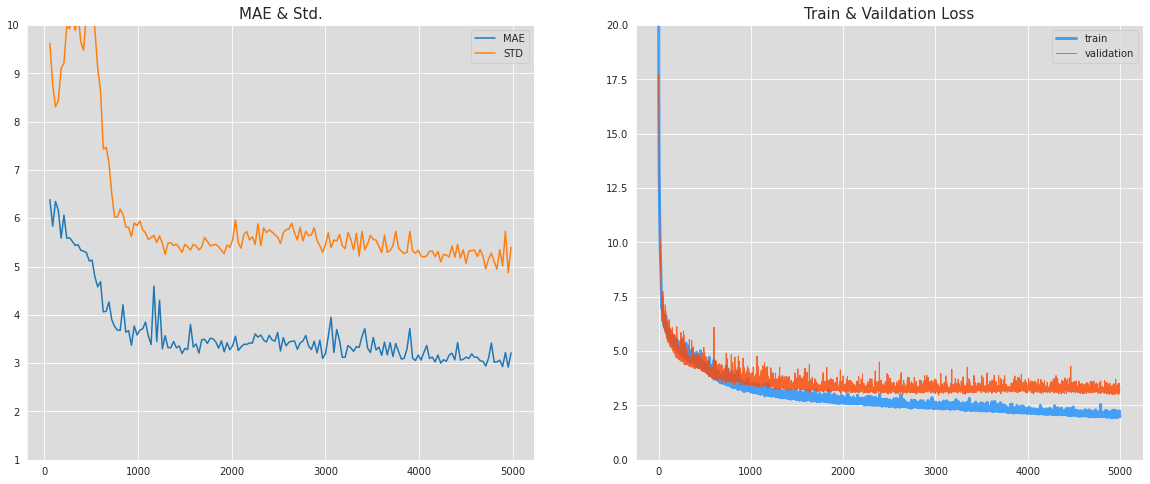

In [ ]:
# Test the trained GNN
preds = test(model, test_loader)
test_mae = np.mean(np.abs(test_targets - preds))
r2 = r2_score(test_targets, preds)
print('Test MAE: {:.4f}\tTest R2 score: {:.4f}'.format(test_mae, r2))
print("--------------HyperParameter Info--------------")
print("Batch : {}, init_lr : {}, l2_coeff : {}, epoch : {}".format(batch_size,init_lr,l2_coeff,n_epochs))
print("criterion : {}, hidden Channel : {}".format(criterion,256))
print("Feature Num. : {}".format(len(elem_feat_names)))
print("-----------------------------------------------")


plt.subplots(1,2,figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(all_seq[1:,0], all_seq[1:,1],label="MAE")
plt.plot(all_seq[1:,0], all_seq[1:,2], label="STD")
plt.ylim(1,10)
plt.title("MAE & Std.",size=15)
plt.legend()
plt.subplot(1,2,2)
# plt.plot(all_seq[1:,0], all_seq[1:,3], label="R2_score")
# plt.title("R2_Score on Training",size=15)
plt.plot(train_losses, label="train", linewidth=3, color="dodgerblue",alpha=0.8)
plt.plot(vali_losses, label="validation", linewidth=1,color="orangered",alpha=0.8)
plt.ylim(0,20)
plt.title("Train & Vaildation Loss",size=15)
plt.legend()

plt.show()

In [ ]:
# Save prediction results
pred_results = list()
for i in range(0, preds.shape[0]):
    pred_results.append([test_smiles[i], test_targets[i].item(), preds[i].item()])
df = pandas.DataFrame(pred_results)
df.columns = ['smiles', 'true_y', 'pred_y']
# df.to_excel('EGCN_Default.xlsx', index=False)
 